Laptop price prediction based on specification
https://www.kaggle.com/datasets/muhammetvarl/laptop-price/data

In [526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from math import sqrt

/Users/kirillsobolev/Documents/GitHub/Introduction-to-ML/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [527]:
df = pd.read_csv("/Users/kirillsobolev/Documents/GitHub/Introduction-to-ML/exercise1/laptop_price.csv", encoding="latin-1")
# data set was not working with default utf encoding
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


<h1>Missing values</h1>

In [528]:
df.isna().sum()

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

<h1>Not related columns.</h1>

In [529]:
# Closer look on Product column, looks like it is just a full name of laptop
df["Product"].unique()

array(['MacBook Pro', 'Macbook Air', '250 G6', 'Aspire 3',
       'ZenBook UX430UN', 'Swift 3', 'Inspiron 3567', 'MacBook 12"',
       'IdeaPad 320-15IKB', 'XPS 13', 'Vivobook E200HA',
       'Legion Y520-15IKBN', '255 G6', 'Inspiron 5379',
       '15-BS101nv (i7-8550U/8GB/256GB/FHD/W10)', 'MacBook Air',
       'Inspiron 5570', 'Latitude 5590', 'ProBook 470', 'LapBook 15.6"',
       'E402WA-GA010T (E2-6110/2GB/32GB/W10)',
       '17-ak001nv (A6-9220/4GB/500GB/Radeon', 'IdeaPad 120S-14IAP',
       'Inspiron 5770', 'ProBook 450',
       'X540UA-DM186 (i3-6006U/4GB/1TB/FHD/Linux)', 'Inspiron 7577',
       'X542UQ-GO005 (i5-7200U/8GB/1TB/GeForce', 'Aspire A515-51G',
       'Inspiron 7773', 'IdeaPad 320-15ISK', 'Rog Strix',
       'X751NV-TY001T (N4200/4GB/1TB/GeForce', 'Yoga Book', 'ProBook 430',
       'Inspiron 3576', '15-bs002nv (i3-6006U/4GB/128GB/FHD/W10)',
       'VivoBook Max', 'GS73VR 7RG',
       'X541UA-DM1897 (i3-6006U/4GB/256GB/FHD/Linux)', 'Vostro 5471',
       'IdeaPad 520S-1

In [530]:
# Delete product and laptop id columns.
df = df.drop(["laptop_ID", "Product"], axis=1)

<h1>Refactoring values to integers.</h1>
In column weight and RAM there are kilograms and gigabytes, let's get rid of them and leave just a number

In [531]:
# check that there is only GB 
df["Ram"].unique()

array(['8GB', '16GB', '4GB', '2GB', '12GB', '6GB', '32GB', '24GB', '64GB'],
      dtype=object)

In [532]:
# extract only numeric value from Ram column
df['Ram'] = df['Ram'].str[:-2].astype(int)

In [533]:
# same for weight, but type has to be float
df["Weight"] = df["Weight"].str[:-2].astype(float)

In [534]:
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


<h1>Text columns.</h1>

1. Company - I think there might be few big companies from which comes biggest part of laptops and some small companies which we could join to some kind of "Other company" category

2. TypeName - feels like there should not be so much categories.

3. OpSys - same as company

<h1>Company name</h1>

In [535]:
df["Company"].value_counts()

Company
Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Razer          7
Mediacom       7
Microsoft      6
Xiaomi         4
Vero           4
Chuwi          3
Google         3
Fujitsu        3
LG             3
Huawei         2
Name: count, dtype: int64

In [536]:
# Let's use one hot encoder to create categorical columns with numeric values
variables = ["Company"]

encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [537]:
# After that we can drop columns with companies which are not so presented in dataset. Basically it will join all of them to "other" category. 
df = df.drop(["Company_Samsung","Company_Razer","Company_Mediacom","Company_Microsoft","Company_Xiaomi","Company_Vero",
              "Company_Chuwi","Company_Google","Company_Fujitsu","Company_LG","Company_Huawei"], axis=1)

<h1>OpSys</h1>

In [538]:
# Next step is dealing with OS column.
df["OpSys"].value_counts()

OpSys
Windows 10      1072
No OS             66
Linux             62
Windows 7         45
Chrome OS         27
macOS             13
Mac OS X           8
Windows 10 S       8
Android            2
Name: count, dtype: int64

In [539]:
# In my opinion, we should divide OS into 2 categories only, Windows and Other. Because only windows here is actually comercial OS and it might affect the price.
# Next code searches for the keyword 'Windows' and changing value to 1 if finds it and to 0 if not
df['OpSys'] = df['OpSys'].str.contains('Windows', 
                                        case=False, regex=True).astype(int)

<h1>Laptop Type</h1>

In [540]:
# Now laptop type 
df["TypeName"].value_counts()

TypeName
Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    121
Workstation            29
Netbook                25
Name: count, dtype: int64

In [541]:
# Let's again use encoder

variables = ["TypeName"]

encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [542]:
# And delete last column to optimize model a little
df = df.drop(["TypeName_Netbook"], axis=1)

In [543]:
df.head()

,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Company_Acer,...,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Toshiba,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation
0,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,0,1.37,1339.69,0,...,0,0,0,0,0,0,0,0,1,0
1,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,0,1.34,898.94,0,...,0,0,0,0,0,0,0,0,1,0
2,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,0,1.86,575.00,0,...,0,1,0,0,0,0,0,1,0,0
3,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,0,1.83,2537.45,0,...,0,0,0,0,0,0,0,0,1,0
4,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,0,1.37,1803.60,0,...,0,0,0,0,0,0,0,0,1,0


After that we are left with only 4 problematic columns.
1. Screen Resolution
2. CPU
3. Memory
4. GPU

<h1>Screen resolution. </h1>
There are too many different names in this dataset to use encoder, but we can extract some values out of it.

We are able to extract pixels amount and we do have Inches data already. That means that we can coint PPI. Pixels Per Inch (PPI) is a measure of Image resolution, the number of individual square pixels per a linear inch within a digital image. 

To count the pixels per inch (PPI) of a monitor when you have its size in inches (the diagonal length of the screen) and its resolution in the format width x height (the number of horizontal and vertical pixels)

The other thing we can find out from this columns is if laptop has touchscreen or not

In [544]:
#Extracting only resolution from ScreenResolution column
df['PPI'] = df['ScreenResolution'].str.extract(r'(\d+x\d+)')
#Creating Width and Height to calculate PPI
df[['Width', 'Height']] = df['PPI'].str.split('x', expand=True).astype('int')
# Finally, count PPI
df['PPI'] = (((df['Width']**2 + df['Height']**2)**0.5)/df['Inches']).round(2)

In [545]:
#Creating Touchscreen column that based on the presence of the term 'Touchscreen'
df['Touchscreen'] = df['ScreenResolution'].str.contains('Touchscreen', 
                                        case=False, regex=True).astype(int)

In [546]:
# Now we can finally drop Resoultion, width, height and inches columns. They all are basically present same information as PPI
df = df.drop(["Width", "Height", "Inches", "ScreenResolution"], axis=1)


<h1>CPU</h1>
Out of the CPU column we can get cpu frequncy value and manufacturer's name.

In [547]:
#Extracting manufacturer name 
df['Cpu_Manufacturer'] = df['Cpu'].str.split(' ').str[0]
#Extracting Ghz number
df['Cpu_Ghz'] = df['Cpu'].str.extract(r'(\d+(\.\d+)?)GHz')[0].astype(float)

In [548]:
df['Cpu_Manufacturer'].value_counts()

Cpu_Manufacturer
Intel      1240
AMD          62
Samsung       1
Name: count, dtype: int64

In [549]:
#Samsung is definetly otlier here, so let's get rid of it
df = df[df['Cpu_Manufacturer'] != 'Samsung']
# as well as cpu column because we don't need it anymore
df = df.drop(['Cpu'], axis=1)

In [550]:
# Use Label Encoder to convert the value of column to 0 or 1

variables = ['Cpu_Manufacturer']
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

<h1>Memory</h1>

From here we can obtain memory type and memory capacity


In [551]:
# Looks like there are 4 types of memory: Flash, SSD, HDD, Hybrid. Also looks like some of laptops have two different storages.
# Another problem is that we have terrabytes and gigabytes in same column, as well as numbers sometimes are represented as integers (1) or floats (1.0)
df['Memory'].unique()

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '32GB Flash Storage', '128GB SSD +  1TB HDD',
       '256GB SSD +  256GB SSD', '64GB Flash Storage',
       '256GB SSD +  1TB HDD', '256GB SSD +  2TB HDD', '32GB SSD',
       '2TB HDD', '64GB SSD', '1.0TB Hybrid', '512GB SSD +  1TB HDD',
       '1TB SSD', '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

In [552]:
# First let's deal with different measurments
df['Memory'] = df['Memory'].str.replace('1TB', '1024GB')
df['Memory'] = df['Memory'].str.replace('1.0TB', '1024GB')
df['Memory'] = df['Memory'].str.replace('2TB', '2048GB')
df['Memory'] = df['Memory'].str.replace('GB', '')
df['Memory'] = df['Memory'].str.replace('  ', '')

In [553]:
# Initialize new columns for storage type and memory
df['Storage_1_Type'] = ''
df['Storage_1_Memory'] = 0
df['Storage_2_Type'] = ''
df['Storage_2_Memory'] = 0

# Define storage types
storage_types = ['SSD', 'HDD', 'Flash', 'Hybrid']

# Extract information for Storage_1 from the 'Memory' column
for storage_type in storage_types:
    # Define condition for the presence of storage_type in the 'Memory' column
    condition = df['Memory'].str.contains(storage_type, case=False, regex=True)
    # Assign storage_type to Storage_1_Type where it's currently empty
    df.loc[condition & (df['Storage_1_Type'] == ''), 'Storage_1_Type'] = storage_type
    # Extract memory information for Storage_1 and assign it where Storage_1_Memory is 0
    df.loc[condition & (df['Storage_1_Memory'] == 0), 
        'Storage_1_Memory'] = df['Memory'].str.extract(f'(\d+) {storage_type}', expand=False).astype(float)

# Extract information for potential second storage
df['Second_Storage'] = df['Memory'].str.extract(r'(\+\s?\d+\s?\w+)', expand=False).fillna('')
df['Has_Second_Storage'] = df['Second_Storage'].apply(lambda x: False if x == '' else True)

# Extract information for Storage_2 from the 'Second_Storage' column
for storage_type in storage_types:
    # Define condition for the presence of storage_type in the 'Second_Storage' column
    condition = df['Second_Storage'].str.contains(storage_type, case=False, regex=True)
    # Assign storage_type to Storage_2_Type where it's currently empty
    df.loc[condition & (df['Storage_2_Type'] == ''), 'Storage_2_Type'] = storage_type
    # Extract memory information for Storage_2 and assign it where Storage_2_Memory is 0
    df.loc[condition & (df['Storage_2_Memory'] == 0), 
        'Storage_2_Memory'] = df['Second_Storage'].str.extract(f'(\d+) {storage_type}', expand=False).astype(float)

# Drop unnecessary columns
df.drop(['Memory', 'Second_Storage', 'Has_Second_Storage'], axis=1, inplace=True)

In [554]:
# Let's use label  hot encoder for first memory storage type as well
variables = ["Storage_1_Type"]

encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

# Drop last column to optimize model
df = df.drop("Storage_1_Type_Hybrid", axis=1)


In [555]:
# Same for 2nd storage type
variables = ["Storage_2_Type"]
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

<h1>GPU</h1>
Out of GPU column we can get only manufacterer name. Different manufacturers use different codes for naming their cards. Sometimes it is quite logical so that the more number in the card's name - the better the card is. But this rule doesn't work 100% times even within same manufacturer, not even saying about how to compare for example Nvidia 1050 and AMD R7.

In [556]:
df['Gpu'].value_counts()

Gpu
Intel HD Graphics 620      281
Intel HD Graphics 520      185
Intel UHD Graphics 620      68
Nvidia GeForce GTX 1050     66
Nvidia GeForce GTX 1060     48
                          ... 
Intel Graphics 620           1
AMD Radeon R5 520            1
AMD Radeon R7                1
Intel HD Graphics 540        1
Nvidia GeForce 960M          1
Name: count, Length: 109, dtype: int64

In [557]:
#Extracting manufacturer name
# This works since it looks like GPU column's first word is always manufacturer name. 
df['Gpu_Manufacturer'] = df['Gpu'].str.split(' ').str[0]
df = df.drop(['Gpu'], axis=1)

In [558]:
#And using encoder and droping last column again 
variables = ["Gpu_Manufacturer"]
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)


In [559]:
# Some rows (3) for some reason contained NaN values
df = df.dropna()

Train model

In [560]:
# if you  have more than one independent variables, list them all here
# leave out the target variable! (dependent variable)
X = df.drop(["Price_euros"], axis=1)

# have only the target variable here (dependent variable)
y = df['Price_euros']

In [561]:
# create train and test sets of your dataset
# random_state is optional, you can lock this down in order to 
# to get same results always
# this examples reserves 30% for test data, 70% for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [562]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [563]:
intercept = lm.intercept_

# this will be a list of variables (to support multiple linear regression)
# the slopes of the different variables in the linear regression formula
coefs = lm.coef_

# if you want to have a nice table of different variable values:
cdf = pd.DataFrame(lm.coef_, X.columns, columns=['Coeff'])
cdf


,Coeff
Ram,6.590298e+01
OpSys,1.695058e+02
Weight,1.782477e+02
Company_Acer,-3.884124e+02
Company_Apple,2.585085e+01
Company_Asus,-3.203492e+02
Company_Dell,-2.822736e+02
Company_HP,-1.660835e+02
Company_Lenovo,-2.801825e+02
Company_MSI,-1.367535e+02


In [564]:
predictions = lm.predict(X_test)

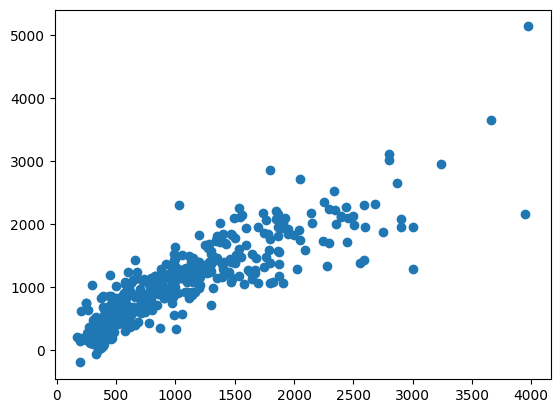

In [565]:
# these values follow a line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
plt.scatter(y_test, predictions)
plt.show()

In [566]:
# MAE - Mean average error
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
# MSE - Mean square error
mse = round(metrics.mean_squared_error(y_test, predictions), 2)
# RMSE - Root mean square error
rmse = round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 2)
# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df = pd.DataFrame({
    'Metric': ['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R-squared'],
    'Base': [mse, rmse, mae, r2]
})
metrics_df

,Metric,Base
0,Mean Squared Error,126232.58
1,Root Mean Squared Error,355.29
2,Mean Absolute Error,260.12
3,R-squared,0.73


Looks like MAE and RMSE in this case are a bit higher than I've expected.

/var/folders/19/0ldx1bc54jx5tvjkrsbcv4040000gn/T/ipykernel_15229/3920156057.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - predictions))


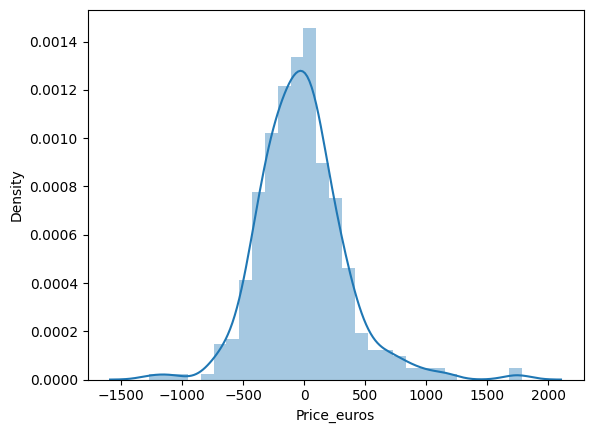

In [567]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - predictions))
plt.show()
plt.close()

In [568]:
# Price's mean is around €1100, Q3 is 1500 and max is 6000, which in my opinion can tell us that there are few outliers ultra gaming laptops. 
# Let's try to retrain model without them
df["Price_euros"].describe()

count    1302.000000
mean     1124.043894
std       699.158856
min       174.000000
25%       599.000000
50%       978.000000
75%      1488.435000
max      6099.000000
Name: Price_euros, dtype: float64

<Axes: xlabel='Price_euros', ylabel='Count'>

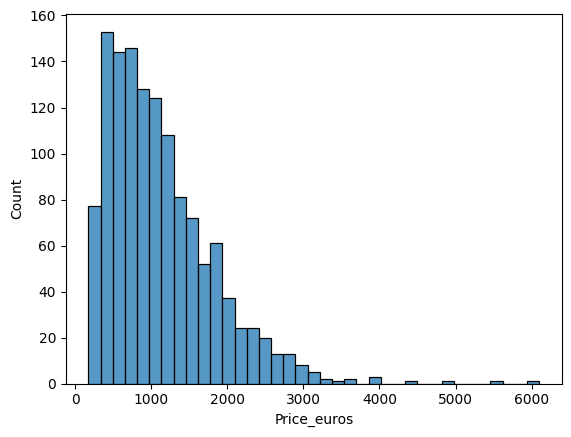

In [569]:
sns.histplot(df["Price_euros"])

In [570]:
# Delete all rows with price more than €3500
df = df.drop(df[df.Price_euros > 3500].index)

In [571]:
df["Price_euros"].describe()

count    1293.000000
mean     1100.971810
std       640.605941
min       174.000000
25%       598.990000
50%       973.000000
75%      1475.000000
max      3499.000000
Name: Price_euros, dtype: float64

In [572]:
# if you  have more than one independent variables, list them all here
# leave out the target variable! (dependent variable)
X = df.drop(["Price_euros"], axis=1)

# have only the target variable here (dependent variable)
y = df['Price_euros']

# create train and test sets of your dataset
# random_state is optional, you can lock this down in order to 
# to get same results always
# this examples reserves 30% for test data, 70% for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [573]:
predictions = lm.predict(X_test)

In [574]:
# MAE - Mean average error
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
# MSE - Mean square error
mse = round(metrics.mean_squared_error(y_test, predictions), 2)
# RMSE - Root mean square error
rmse = round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 2)
# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df["No outliers"] = [mse, rmse, mae, r2]
metrics_df

,Metric,Base,No outliers
0,Mean Squared Error,126232.58,97327.03
1,Root Mean Squared Error,355.29,311.97
2,Mean Absolute Error,260.12,239.35
3,R-squared,0.73,0.77


Look's a bit better now

/var/folders/19/0ldx1bc54jx5tvjkrsbcv4040000gn/T/ipykernel_15229/3920156057.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - predictions))


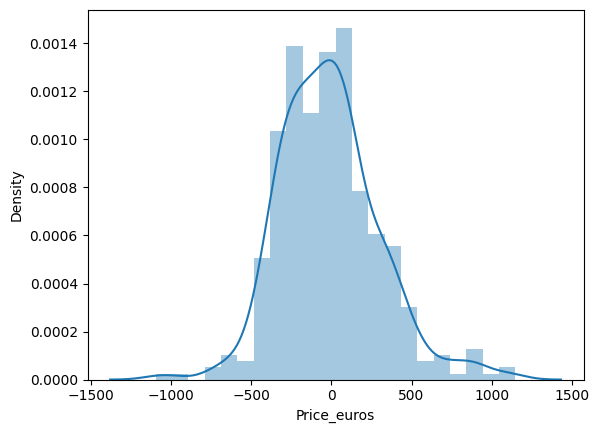

In [575]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - predictions))
plt.show()
plt.close()

<h1>Extreme gradient boosting</h1>
Let's try same dataset using XGBRegressor.

In [576]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_base = xgb_model.predict(X_test)

mse = round(metrics.mean_squared_error(y_test, y_base), 2)
rmse = round(metrics.mean_squared_error(y_test, y_base, squared=False), 2)
mae = round(metrics.mean_absolute_error(y_test, y_base), 2)
r2 = round(metrics.r2_score(y_test, y_base), 2)

metrics_df["XGB"] = [mse, rmse, mae, r2]

metrics_df

/Users/kirillsobolev/Documents/GitHub/Introduction-to-ML/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Metric,Base,No outliers,XGB
0,Mean Squared Error,126232.58,97327.03,69016.990218
1,Root Mean Squared Error,355.29,311.97,262.710849
2,Mean Absolute Error,260.12,239.35,180.370969
3,R-squared,0.73,0.77,0.835270


<h1>Optuna</h1>

In [577]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    return rmse

In [578]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
final_model = XGBRegressor(**best_params, random_state=101)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

final_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

print(f"Best Parameters: {best_params}")
print(f"Final Root Mean Squared Error: {final_rmse}")

[I 2024-03-20 08:22:58,023] A new study created in memory with name: no-name-1ec59753-41d1-4daa-8930-55ff2b187084
/Users/kirillsobolev/Documents/GitHub/Introduction-to-ML/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-03-20 08:22:58,164] Trial 0 finished with value: 259.5267109756681 and parameters: {'learning_rate': 0.09172092088691587, 'n_estimators': 237, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.9653764360291497, 'colsample_bytree': 0.9054963426696861, 'gamma': 0.14379783266519286, 'reg_alpha': 0.10471541874855972, 'reg_lambda': 0.08887258383552743}. Best is trial 0 with value: 259.5267109756681.
/Users/kirillsobolev/Documents/GitHub/Introduction-to-ML/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecat

Best Parameters: {'learning_rate': 0.010554669497143199, 'n_estimators': 1457, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.572747538758108, 'colsample_bytree': 0.5244089493234563, 'gamma': 0.8950229851611143, 'reg_alpha': 0.1626818366230579, 'reg_lambda': 0.25108046950833457}
Final Root Mean Squared Error: 243.33860673963864


/Users/kirillsobolev/Documents/GitHub/Introduction-to-ML/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [579]:
mse = round(metrics.mean_squared_error(y_test, y_pred), 2)
rmse = round(metrics.mean_squared_error(y_test, y_pred, squared=False), 2)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 2)
r2 = round(metrics.r2_score(y_test, y_pred), 2)

metrics_df['Optuna tuned'] = [mse, rmse, mae, r2]
metrics_df

/Users/kirillsobolev/Documents/GitHub/Introduction-to-ML/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Metric,Base,No outliers,XGB,Optuna tuned
0,Mean Squared Error,126232.58,97327.03,69016.990218,59213.68
1,Root Mean Squared Error,355.29,311.97,262.710849,243.34
2,Mean Absolute Error,260.12,239.35,180.370969,161.57
3,R-squared,0.73,0.77,0.835270,0.86


In [ ]:
# TODO comments, go deeper inside optuna